In [112]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import auto_arima
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore", category=FutureWarning) 

This section performs a Time Series Analysis of our data.

In [3]:
df = pd.read_csv("hotel_bookings.csv")

Let's take a look at our dataset.

In [4]:
df.head(100)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Resort Hotel,1,72,2015,July,27,3,0,2,2,...,No Deposit,240.0,NaN,0,Transient,73.80,0,1,Canceled,2015-06-29
96,Resort Hotel,1,63,2015,July,27,3,2,5,2,...,No Deposit,242.0,NaN,0,Transient,117.00,0,1,Canceled,2015-05-13
97,Resort Hotel,0,63,2015,July,27,3,2,5,3,...,No Deposit,105.0,NaN,0,Transient,196.54,0,1,Check-Out,2015-07-10
98,Resort Hotel,0,101,2015,July,27,3,2,5,2,...,No Deposit,240.0,NaN,0,Transient,99.30,1,2,Check-Out,2015-07-10


From the first look, we can see that column Company has a lot of NAN values.

In [5]:
percNAN = (df['company'].isna().sum()/df.shape[0])*100
percNAN

94.30689337465449

Since 94% of the column is NAN, we can remove it.

In [6]:
df.drop('company', inplace=True, axis=1)

Let's combine the arrival year, month and day into one column and make it the dataframe index.

In [7]:
df.rename(columns = {'arrival_date_year' : 'year', 'arrival_date_month':'month', 'arrival_date_day_of_month':'day'},inplace = True)
df['arrival_date'] = pd.to_datetime(df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+df['day'].astype(str), infer_datetime_format=True)
df.head()

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [128]:
df.set_index(df['arrival_date'], inplace=True)
df.head()

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
arrival_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2015-07-01,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2015-07-01,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
2015-07-01,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
2015-07-01,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


Let's explore column adr. 

In [9]:
df.nlargest(5,'adr', 'first')

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
arrival_date,,,,,,,,,,,,,,,,,,,,,
2016-03-25,City Hotel,1,35,2016,March,13,25,0,1,2,...,Non Refund,12.0,0,Transient,5400.0,0,0,Canceled,2016-02-19,2016-03-25
2017-05-09,City Hotel,0,0,2017,May,19,9,0,1,1,...,No Deposit,159.0,0,Transient,510.0,0,0,Check-Out,2017-05-10,2017-05-09
2015-07-15,Resort Hotel,0,1,2015,July,29,15,0,1,2,...,No Deposit,NaN,0,Transient,508.0,1,0,Check-Out,2015-07-16,2015-07-15
2016-12-31,City Hotel,0,81,2016,December,53,31,1,1,2,...,No Deposit,NaN,0,Transient-Party,451.5,0,4,Check-Out,2017-01-02,2016-12-31
2017-08-01,Resort Hotel,1,378,2017,August,31,1,4,10,2,...,No Deposit,314.0,0,Transient,450.0,0,0,Canceled,2016-07-22,2017-08-01


We can see that there is an outlier of 5400. We can remove it.

In [10]:
df = df[df['adr'] != 5400]
df.nlargest(5,'adr', 'first')

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
arrival_date,,,,,,,,,,,,,,,,,,,,,
2017-05-09,City Hotel,0,0,2017,May,19,9,0,1,1,...,No Deposit,159.0,0,Transient,510.0,0,0,Check-Out,2017-05-10,2017-05-09
2015-07-15,Resort Hotel,0,1,2015,July,29,15,0,1,2,...,No Deposit,NaN,0,Transient,508.0,1,0,Check-Out,2015-07-16,2015-07-15
2016-12-31,City Hotel,0,81,2016,December,53,31,1,1,2,...,No Deposit,NaN,0,Transient-Party,451.5,0,4,Check-Out,2017-01-02,2016-12-31
2017-08-01,Resort Hotel,1,378,2017,August,31,1,4,10,2,...,No Deposit,314.0,0,Transient,450.0,0,0,Canceled,2016-07-22,2017-08-01
2017-08-13,Resort Hotel,1,59,2017,August,33,13,2,4,2,...,No Deposit,250.0,0,Transient,437.0,0,0,Canceled,2017-08-03,2017-08-13


Now we can plot ADR vs time.

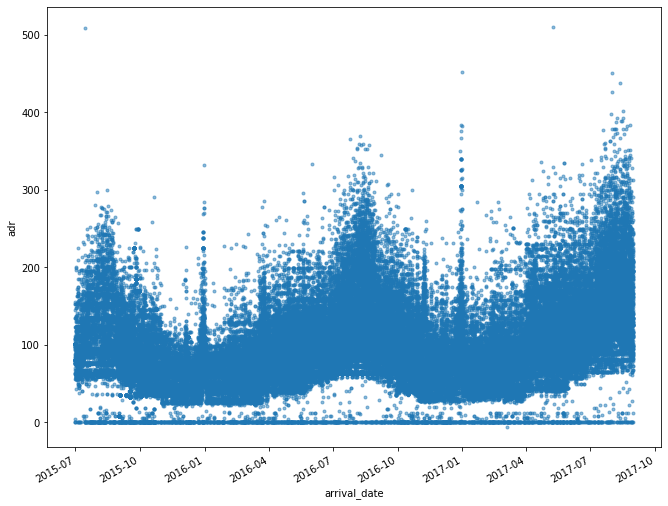

In [135]:
ax = df['adr'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True);
ax[0].set_ylabel("adr");

There is an interesting pattern in the summer here. Let's zoom in on it.

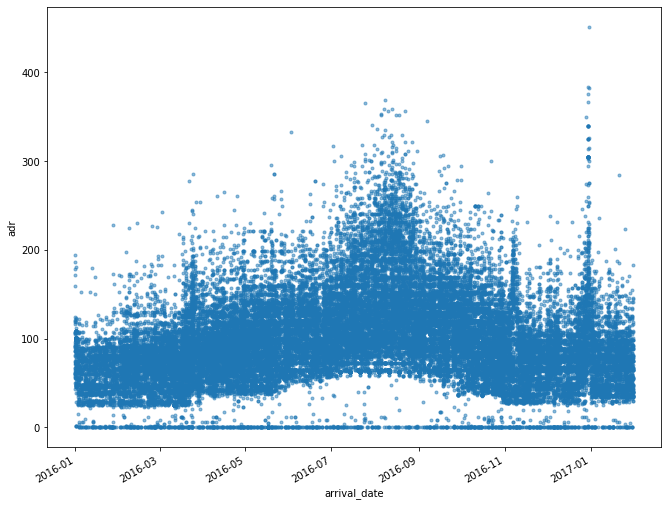

In [136]:
ax = df.loc['2016-01':'2017-01', 'adr'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True);
ax[0].set_ylabel("adr");

It can be inferred that the Average Daily Rate increases in the summer (months 7 to 8) which makes sense since the average daily rate is the total number of transactions over number of staying nights and both generally increase in the summer.

However, there are too many samples to have a clear observation. Let's resample our data such that the weekly observations are plotted.

In [13]:
df_weekly_mean = df['adr'].resample('W').mean()
df_weekly_mean.head(3)

arrival_date
2015-07-05     90.397743
2015-07-12     94.156404
2015-07-19    101.486901
Freq: W-SUN, Name: adr, dtype: float64

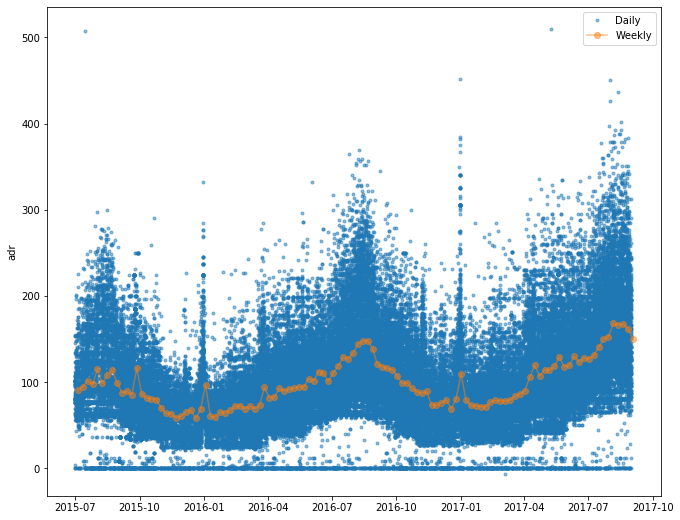

In [138]:
fig, ax = plt.subplots(figsize=(11,9))
ax.plot(df['adr'],marker='.', alpha=0.5, linestyle='None', label = 'Daily');
ax.plot(df_weekly_mean,marker='o', alpha=0.5, linestyle='-', label = 'Weekly');
ax.legend();
ax.set_ylabel("adr");

Resampling outputs a lower frequency data. What if we can achieve similar results without decreasing the frequency? This is where rolling is needed. Rolling overlaps and "rolls" the data so that the output is of the same frequency as the original. We will use 7-day rolling. We do so by first getting the mean for repeated days by resampling to 1D and rolling the output.

In [15]:
df_7d = df['adr'].resample("1d").mean().rolling(window=7, min_periods=1).mean()
df_7d.head(10)

arrival_date
2015-07-01    92.828934
2015-07-02    87.517209
2015-07-03    90.739151
2015-07-04    89.449932
2015-07-05    91.560474
2015-07-06    91.376906
2015-07-07    91.548697
2015-07-08    89.714791
2015-07-09    89.492294
2015-07-10    91.608639
Freq: D, Name: adr, dtype: float64

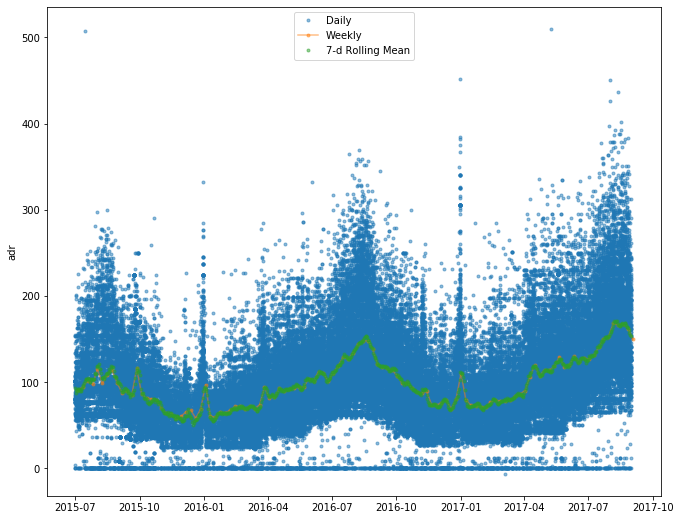

In [139]:
fig, ax = plt.subplots(figsize=(11,9))
ax.plot(df['adr'],marker='.', alpha=0.5, linestyle='None', label = 'Daily');
ax.plot(df_weekly_mean,marker='.', alpha=0.5, linestyle='-', label = 'Weekly');
ax.plot(df_7d,marker='.', alpha=0.5, linestyle='None', label = '7-d Rolling Mean');
ax.legend();
ax.set_ylabel("adr");

As you can see, the results are identical.
Now, we analyze the trend in the data.

In [17]:
df_365 = df['adr'].resample("1d").mean().rolling(window=365, center=True, min_periods=360).mean()

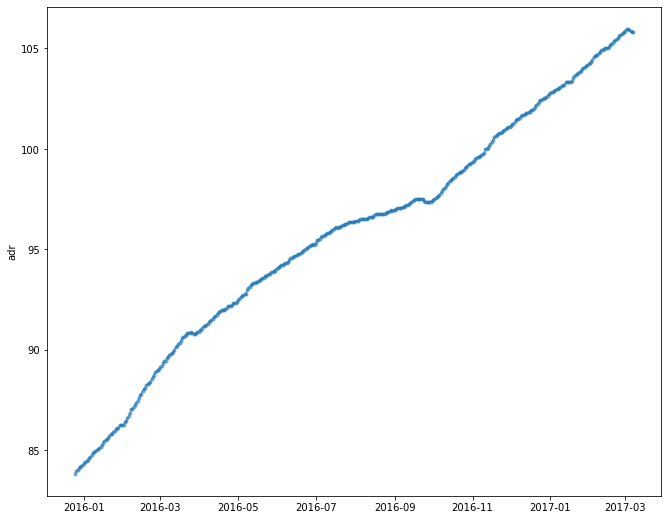

In [140]:
fig, ax = plt.subplots(figsize=(11,9))
ax.plot(df_365,marker='.', alpha=0.5, linestyle='-', label = 'Trend');
ax.set_ylabel("adr");

Working with the resampled data, we analyze the seasonality. 

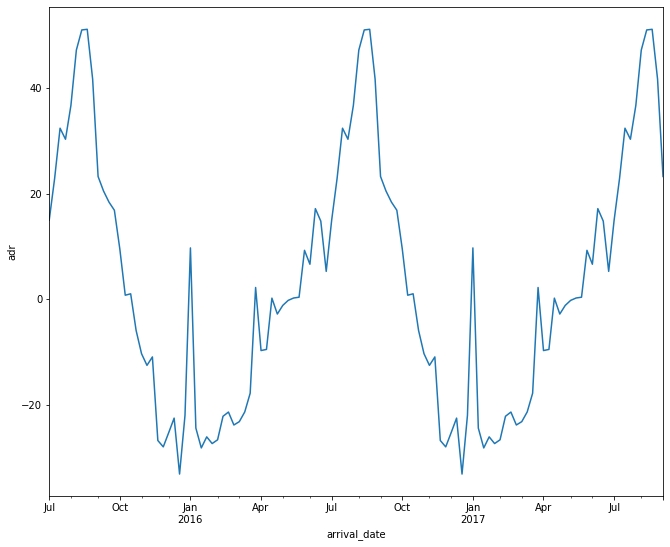

In [146]:
sd = seasonal_decompose(df_weekly_mean, model='additive').seasonal.plot(figsize=(11,9))
sd.set_ylabel("adr");

Looking at the result, we can further prove that there is a seasonality component in our data, which was intuitive from the original data.
This, the variance in the data and the trend make the time series unstationary. Let's try to make it stationary using SARIMA.

First, we split the dataset into training and test sets.

Then we take log10 of the data to remove the variance in the data.

In [114]:
values = df_weekly_mean.values
size = 90
train, test = values[0:size], values[size:len(values)]
train_log = np.log10(train)
test_log = np.log10(test)

Analyzing the partial autocorrelation and autocorrelation of the data gives us a starting point for the q and p parameters.

From the graphs, we can deduce that p = 1 and q = 6. We will also use d = 1 for detrending.

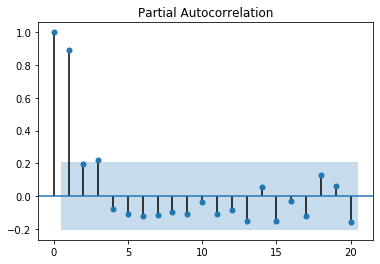

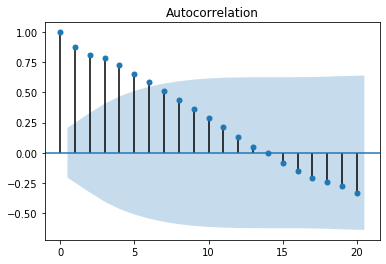

In [21]:
plot_pacf(train);
plot_acf(train);

In [22]:
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot();
# residuals.plot(kind='kde');
# print(residuals.describe())

In [125]:
original = train_log.copy().tolist()
predictions = original.copy()
for t in range(len(test_log)):
    model = sm.tsa.statespace.SARIMAX(original, order=(1,1,6))
    model_fit = model.fit(maxiter=200)
    output = model_fit.forecast()
    predictions.append(output[0])
    original.append(test_log[t])
    print('predicted=%f, expected=%f' % (output[0], test_log[t]))
# model_fit = auto_arima(train)
# predictions.extend(model_fit.predict(n_periods=test.shape[0]))

predicted=1.913721, expected=1.934728
predicted=1.923435, expected=1.953339
predicted=1.942377, expected=2.024739
predicted=2.001926, expected=2.076426
predicted=2.049982, expected=2.029407
predicted=2.037238, expected=2.057713
predicted=2.073542, expected=2.055711
predicted=2.052514, expected=2.072089
predicted=2.073633, expected=2.110397
predicted=2.108950, expected=2.071048
predicted=2.072980, expected=2.075995
predicted=2.089211, expected=2.112818
predicted=2.099749, expected=2.091188
predicted=2.090068, expected=2.107008
predicted=2.110315, expected=2.102216
predicted=2.098886, expected=2.117082
predicted=2.117529, expected=2.146075
predicted=2.133577, expected=2.175807
predicted=2.161570, expected=2.183229
predicted=2.178446, expected=2.225059
predicted=2.219382, expected=2.221058
predicted=2.219218, expected=2.223938
predicted=2.235653, expected=2.209494
predicted=2.221518, expected=2.174707


After forecasting, we will draw the predicted values against the real values. As shown in the figure, they are very close.

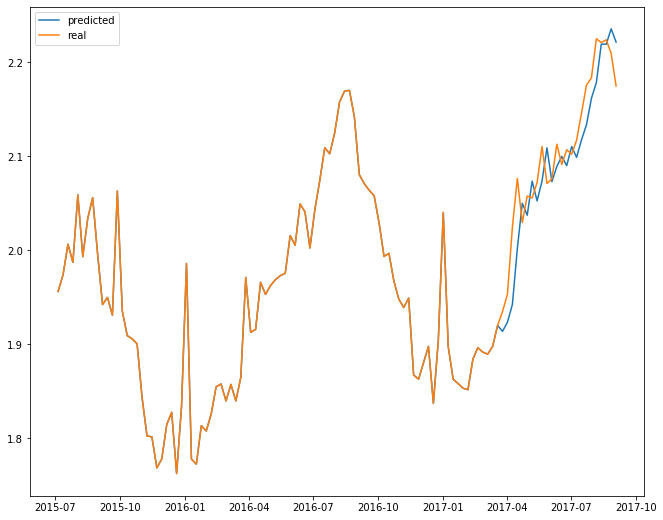

In [127]:
fig, ax = plt.subplots(figsize = (11,9))
plt.plot(df_weekly_mean.index, predictions)
plt.plot(df_weekly_mean.index, original)
ax.legend(["predicted", "real"]);